#### About
Indian Food classification via Transfer Learning by using EfficientNet B7 as a feature extractor.

Dataset Link- https://www.kaggle.com/datasets/l33tc0d3r/indian-food-classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import os
os.chdir('/content/drive/MyDrive/Datasets')
!rm -rf Food\ Classification
!unzip Food.zip

Streaming output truncated to the last 5000 lines.
  inflating: Food Classification/train/chai/0116.jpg  
  inflating: Food Classification/train/chai/0009.jpg  
  inflating: Food Classification/train/chai/0280.jpg  
  inflating: Food Classification/train/chai/0234.jpg  
  inflating: Food Classification/train/chai/0126.jpg  
  inflating: Food Classification/train/chai/0336.jpg  
  inflating: Food Classification/train/chai/0367.jpg  
  inflating: Food Classification/train/chai/0281.jpg  
  inflating: Food Classification/train/chai/0070.jpg  
  inflating: Food Classification/train/chai/0095.jpg  
  inflating: Food Classification/train/chai/0205.jpg  
  inflating: Food Classification/train/chai/0010.jpg  
  inflating: Food Classification/train/chai/0002.jpg  
  inflating: Food Classification/train/chai/0034.jpg  
  inflating: Food Classification/train/chai/0231.jpg  
  inflating: Food Classification/train/chai/0209.jpg  
  inflating: Food Classification/train/chai/0161.jpg  
  inflating: F

In [20]:
import torch
from torch import Tensor
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import tarfile
#imports for loading images from the dataset structure
from torchvision.datasets import ImageFolder
from PIL import Image, ImageEnhance
import numpy as np
from torchvision import models
from torchsummary import summary
import time



In [21]:
#dataset is stored in seperate directory with label names inside train test for each of the classes.
root_dir="/content/drive/MyDrive/Datasets/Food Classification/"


In [22]:
#image enhancement function while training
enhancers = {
    0: lambda image, f: ImageEnhance.Color(image).enhance(f),
    1: lambda image, f: ImageEnhance.Contrast(image).enhance(f),
    2: lambda image, f: ImageEnhance.Brightness(image).enhance(f),
    3: lambda image, f: ImageEnhance.Sharpness(image).enhance(f)
}

factors = {
        0: lambda: np.random.normal(1.0, 0.3),
        1: lambda: np.random.normal(1.0, 0.1),
        2: lambda: np.random.normal(1.0, 0.1),
        3: lambda: np.random.normal(1.0, 0.3),
    }
    

def enhance(image):
    order = [0, 1, 2, 3]
    np.random.shuffle(order)
    for i in order:
        f = factors[i]()
        image = enhancers[i](image, f)
    return image

In [23]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224),Image.LANCZOS),
    #transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(enhance),
    transforms.ToTensor(),
    #transforms.Normalize(
        #mean=[0.485, 0.456, 0.406],
     #   std=[0.229, 0.224, 0.225]
    #),
                                    ])


val_transform = transforms.Compose([
    #transforms.Resize(380, Image.LANCZOS),
    transforms.Resize((224, 224),Image.LANCZOS),
    transforms.ToTensor(),
    #transforms.Normalize(
    #    mean=[0.485, 0.456, 0.406],
    #    std=[0.229, 0.224, 0.225]
    #),
                                    ])

# standard deviation and mean values -
train_data = ImageFolder(root_dir+'train', transform=train_transform)
val_data = ImageFolder(root_dir+'val',transform=val_transform)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [24]:
# let's have a look at the dataset dynamics
image,label = train_data[4]
print(image.shape)
print(label)

torch.Size([3, 224, 224])
0


In [25]:
print(train_data.classes)
print(len(train_data.classes))

['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa']
20


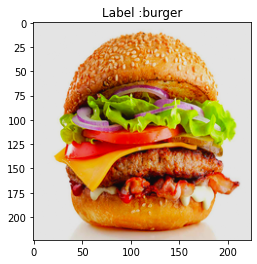

In [26]:
#Visualising data samples from train and test dataset
for i in range(232,233):
    image,label = train_data[i]
    plt.imshow(image.permute(1,2,0)) # 0th dimension should come last and 1st and 2nd dimension should come first
    plt.title("Label :{}".format(train_data.classes[label]))
    plt.show()

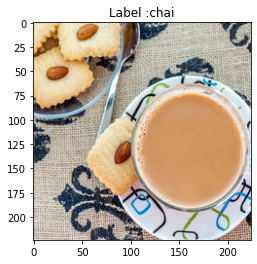

In [27]:
#Visualising data samples from train and test dataset
for i in range(23,24):
    image,label = val_data[i]
    plt.imshow(image.permute(1,2,0)) # 0th dimension should come last and 1st and 2nd dimension should come first
    plt.title("Label :{}".format(val_data.classes[label]))
    plt.show()

In [28]:
#creating dataloader
batch_size =128
train_loader = DataLoader(train_data,batch_size,shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size,shuffle=True,  num_workers=4, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [29]:
torch.cuda.is_available()

True

In [30]:
num_classes = len(train_data.classes)

In [31]:
efficient_b7_model = models.efficientnet_b7(pretrained=True)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
print(efficient_b7_model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [33]:
# freezing base layers
for param in efficient_b7_model.parameters():
    param.requires_grad = False

#gradients will not be computed during backpropagation

In [34]:
# defining the classification head
efficient_b7_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=2560, out_features=num_classes,
    bias=True)
)

# since NLL loss doesn't have softmax pre-implemented
efficient_b7_model.classifier.add_module("7",nn.LogSoftmax(dim=1))

In [35]:
efficient_b7_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [36]:
# defining the optimizer and loss function
loss_func = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(efficient_b7_model.parameters())


In [37]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/len(train_data) 
        avg_train_acc = train_acc/len(train_data) 

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/len(val_data)  
        avg_valid_acc = valid_acc/len(val_data) 

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
efficient_b7_model = efficient_b7_model.to("cuda")

num_epochs = 10
model, history = train_and_validate(efficient_b7_model, loss_func, optimizer, num_epochs)

Epoch: 1/10


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


Epoch : 001, Training: Loss: 2.4161, Accuracy: 47.0170%, 
		Validation : Loss : 1.8818, Accuracy: 59.0000%, Time: 245.4744s
Epoch: 2/10


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch : 002, Training: Loss: 1.6799, Accuracy: 64.8653%, 
		Validation : Loss : 1.4796, Accuracy: 66.5000%, Time: 247.0896s
Epoch: 3/10


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


Epoch : 003, Training: Loss: 1.3829, Accuracy: 68.8481%, 
		Validation : Loss : 1.2879, Accuracy: 68.5000%, Time: 245.9938s
Epoch: 4/10


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


Epoch : 004, Training: Loss: 1.2235, Accuracy: 69.9389%, 
		Validation : Loss : 1.1876, Accuracy: 71.5000%, Time: 240.7802s
Epoch: 5/10


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


Epoch : 005, Training: Loss: 1.1265, Accuracy: 71.8889%, 
		Validation : Loss : 1.1004, Accuracy: 72.5000%, Time: 243.1145s
Epoch: 6/10


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch : 006, Training: Loss: 1.0500, Accuracy: 73.6407%, 
		Validation : Loss : 1.0320, Accuracy: 71.5000%, Time: 239.7289s
Epoch: 7/10


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch : 007, Training: Loss: 0.9976, Accuracy: 74.1530%, 
		Validation : Loss : 1.0075, Accuracy: 69.0000%, Time: 239.9489s
Epoch: 8/10


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch : 008, Training: Loss: 0.9425, Accuracy: 76.2353%, 
		Validation : Loss : 0.9836, Accuracy: 70.5000%, Time: 239.4110s
Epoch: 9/10


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch : 009, Training: Loss: 0.9087, Accuracy: 75.8718%, 
		Validation : Loss : 0.9744, Accuracy: 68.5000%, Time: 240.8063s
Epoch: 10/10


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


Epoch : 010, Training: Loss: 0.8925, Accuracy: 76.3180%, 
		Validation : Loss : 0.9778, Accuracy: 68.5000%, Time: 256.5343s


In [41]:
#saving model
torch.save(efficient_b7_model.state_dict(), 'efficient_net_b7_indian_food.pth')

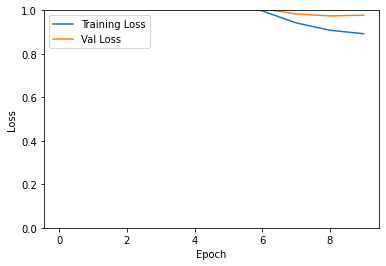

In [46]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

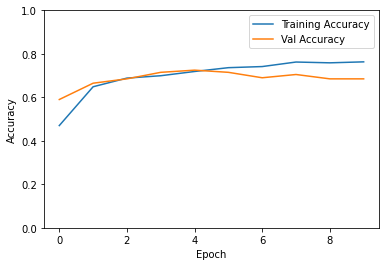

In [43]:
plt.plot(history[:,2:4])
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

In [44]:
idx_to_class = {v: k for k, v in train_data.class_to_idx.items()}
print(idx_to_class)


def predict(model, test_image_name):
    
    test_image = Image.open(test_image_name).convert('RGB')
    print(np.shape(test_image))
    plt.imshow(test_image)
    
    mean = [0.485,0.485,0.485] 
    std = [0.229,0.229,0.229]
    transform_norm = transforms.Compose([transforms.ToTensor(), 
          transforms.Resize((224,224)),transforms.Normalize(mean, std)])
    # get normalized image
    img_normalized = transform_norm(test_image).float()
    print(img_normalized.shape)

    if torch.cuda.is_available():
        test_image_tensor = img_normalized.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = img_normalized.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        prob = torch.exp(out)
        prob_, class_ = prob.topk(3, dim=1)
        class_ = class_.cpu().numpy()
        for i in range(3):
            print("Predcition", i+1, ":", idx_to_class[class_[0][i]], ", Score: ", prob_.cpu().numpy()[0][i])

{0: 'burger', 1: 'butter_naan', 2: 'chai', 3: 'chapati', 4: 'chole_bhature', 5: 'dal_makhani', 6: 'dhokla', 7: 'fried_rice', 8: 'idli', 9: 'jalebi', 10: 'kaathi_rolls', 11: 'kadai_paneer', 12: 'kulfi', 13: 'masala_dosa', 14: 'momos', 15: 'paani_puri', 16: 'pakode', 17: 'pav_bhaji', 18: 'pizza', 19: 'samosa'}


(1382, 1600, 3)
torch.Size([3, 224, 224])
Predcition 1 : chai , Score:  0.14077003
Predcition 2 : chapati , Score:  0.12610844
Predcition 3 : pizza , Score:  0.11808123


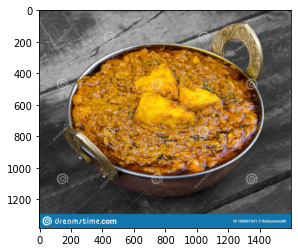

In [45]:
predict(model, '/content/drive/MyDrive/Datasets/Food Classification/val/kadai_paneer/0407.jpg')


(617, 1000, 3)
torch.Size([3, 224, 224])
Predcition 1 : chapati , Score:  0.4358946
Predcition 2 : momos , Score:  0.15563558
Predcition 3 : chai , Score:  0.1330435


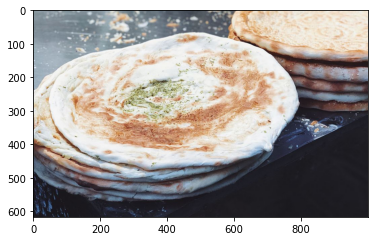

In [54]:
predict(model, '/content/drive/MyDrive/Datasets/Food Classification/val/chapati/0407.jpg')
